In [1]:
# Find path to PySpark.
import findspark
findspark.init('/Users/Steve/spark-2.0.2-bin-hadoop2.6')

# Import PySpark and initialize SparkContext object.
import pyspark
sc = pyspark.SparkContext()

In [2]:

#Print first 5 elements of RDD
raw_data = sc.textFile("hamlet.txt")
raw_data.take(5)


['\tHAMLET', '', '', '\tDRAMATIS PERSONAE', '']

In [3]:
#From the output above, we see the data is delimited by "\t". Let's apply a map function to splice each entry.

splice_data = raw_data.map(lambda splice : splice.split('\t'))
splice_data.take(5)

[['', 'HAMLET'], [''], [''], ['', 'DRAMATIS PERSONAE'], ['']]

In [4]:
#Goal: Find lines where Hamlet speaks

def hamlet_speaks_filter(row):
    id = row[0]
    hamlet_speaks = False
    
    if 'HAMLET' in row[0]:
        hamlet_speaks = True
        
    if hamlet_speaks:
        yield id, 'Hamlet Speaks!' 

In [5]:
hamlet_lines = splice_data.flatMap(lambda x: hamlet_speaks_filter(x))
hamlet_lines.take(10)

[('HAMLET', 'Hamlet Speaks!'),
 ('HAMLET', 'Hamlet Speaks!'),
 ('HAMLET', 'Hamlet Speaks!'),
 ('HAMLET', 'Hamlet Speaks!'),
 ('HAMLET', 'Hamlet Speaks!'),
 ('HAMLET', 'Hamlet Speaks!'),
 ('HAMLET', 'Hamlet Speaks!'),
 ('HAMLET', 'Hamlet Speaks!'),
 ('HAMLET', 'Hamlet Speaks!'),
 ('HAMLET', 'Hamlet Speaks!')]

In [6]:
#Goal: Use filter to return lines of Hamlet dialogue

def hamlet_speaks_filter2(x):
    if 'HAMLET' in x[0]:
        return  True
    else:
        return False

hamlet_lines2 = splice_data.filter(lambda row: hamlet_speaks_filter2(row))
hamlet_lines2.take(5)

[['HAMLET', 'son to the late, and nephew to the present king.'],
 ['HAMLET', '[Aside]  A little more than kin, and less than kind.'],
 ['HAMLET', "Not so, my lord; I am too much i' the sun."],
 ['HAMLET', 'Ay, madam, it is common.'],
 ['HAMLET', "Seems, madam! nay it is; I know not 'seems.'"]]

In [7]:
#Remove the first line, which is a header

hamlet_first_line = hamlet_lines2.take(1)
hamlet_lines3 = hamlet_lines2.filter(lambda line: line[1] != hamlet_first_line[0][1])
hamlet_lines3.take(5)

[['HAMLET', '[Aside]  A little more than kin, and less than kind.'],
 ['HAMLET', "Not so, my lord; I am too much i' the sun."],
 ['HAMLET', 'Ay, madam, it is common.'],
 ['HAMLET', "Seems, madam! nay it is; I know not 'seems.'"],
 ['HAMLET', 'I shall in all my best obey you, madam.']]

In [8]:
#Find number of lines where Hamlet Spoke
num_hamlet_lines = hamlet_lines3.count()
print ('Number of Hamlet Lines = ', num_hamlet_lines)
hamlet_dialogue = hamlet_lines3.collect()
hamlet_line_101 = hamlet_dialogue[100][1]
print ('Hamlet\'s 101\'st line is: ', hamlet_line_101)
        

Number of Hamlet Lines =  265
Hamlet's 101'st line is:  [Aside]  Nay, then, I have an eye of you.--If you


In [9]:
import string
#Find the 20 highest frequency words Hamlet spoke

#Remove "HAMLET" header
hamlet_lines4 = hamlet_lines3.map(lambda line : line[1])
print ('Removed HAMLET Header')
print (hamlet_lines4.take(5), '\n')

#Splice by space
hamlet_lines5 = hamlet_lines4.flatMap(lambda line: line.split(' '))
print ('Extract individual words')
print (hamlet_lines5.take(15), '\n')

#Remove all punctuation and empty lines
hamlet_lines6 = hamlet_lines5.map(lambda line: line.translate(str.maketrans('','', string.punctuation )))\
     .filter(lambda line: line!='')
print ('Remove punctuation')
print (hamlet_lines6.take(15), '\n')

#Tally words and take top 20 most frequent words
print ('Most frequently used words')
hamlet_words = hamlet_lines6.map(lambda row: (row.lower(), 1))\
    .reduceByKey(lambda x, y: x+y)\
    .takeOrdered(20, key= lambda x : -x[1] )
print (hamlet_words)

Removed HAMLET Header
['[Aside]  A little more than kin, and less than kind.', "Not so, my lord; I am too much i' the sun.", 'Ay, madam, it is common.', "Seems, madam! nay it is; I know not 'seems.'", 'I shall in all my best obey you, madam.'] 

Extract individual words
['[Aside]', '', 'A', 'little', 'more', 'than', 'kin,', 'and', 'less', 'than', 'kind.', 'Not', 'so,', 'my', 'lord;'] 

Remove punctuation
['Aside', 'A', 'little', 'more', 'than', 'kin', 'and', 'less', 'than', 'kind', 'Not', 'so', 'my', 'lord', 'I'] 

Most frequently used words
[('you', 69), ('i', 68), ('the', 56), ('a', 54), ('it', 36), ('to', 32), ('not', 30), ('of', 28), ('and', 26), ('is', 25), ('that', 24), ('my', 23), ('but', 22), ('your', 18), ('do', 17), ('sir', 17), ('be', 16), ('this', 15), ('in', 15), ('for', 15)]


In [10]:
#NLTK Natural Language Processing Library
import nltk

In [ ]:
#Open window and download stopwords database
nltk.download()

In [11]:
from nltk.corpus import stopwords
#Remove stop words and print 20 most commonly used words
stop_words = set(stopwords.words('English'))
hamlet_words2 = hamlet_lines6.map(lambda row: (row.lower(), 1))\
    .filter(lambda line: line[0] not in stop_words)\
    .reduceByKey(lambda x, y: x+y)\
    .takeOrdered(20, key= lambda x : -x[1] )
print (hamlet_words2)

[('sir', 17), ('well', 14), ('mother', 12), ('man', 11), ('ay', 10), ('come', 10), ('thou', 8), ('let', 8), ('upon', 8), ('speak', 8), ('king', 8), ('good', 8), ('shall', 8), ('nay', 8), ('play', 7), ('ill', 6), ('horatio', 6), ('tis', 6), ('look', 6), ('go', 6)]


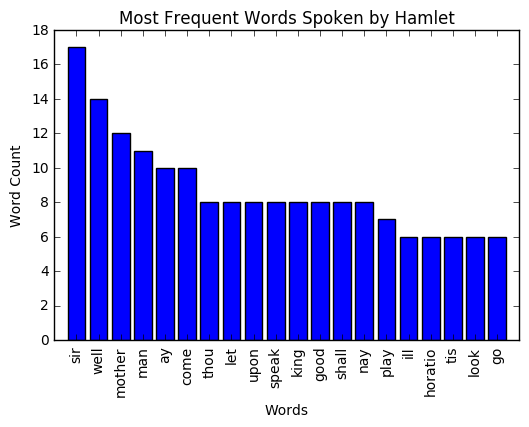

In [17]:
#Plot bar graph of 10 most popular words spoken by Hamlet
import matplotlib.pyplot as plt

words =[x[0] for x in hamlet_words2]
word_count = [x[1] for x in hamlet_words2]
fig2 = plt.figure()
sub = fig2.add_subplot(111)
sub.bar(left=range(1,len(word_count)+1), height=word_count, align = 'center')
#sub.set_xaxis([min(years),max(years)])
sub.set_xlabel('Words')
sub.set_ylabel('Word Count')
sub.set_xticks(range(1,len(word_count)+1))
sub.set_xticklabels(words, rotation = 90)
sub.set_xlim(right = len(word_count)+1)
sub.set_title('Most Frequent Words Spoken by Hamlet')
plt.show()

In [18]:
sc.stop()
